<a href="https://colab.research.google.com/github/normandoamazonas/FinalProject/blob/master/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure, img_as_ubyte, color
from skimage.util import compare_images
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

**Read the satellite images**

The first step is to read the two images for comparison.

Text(0.5, 1.0, 'LANDSAT 2017')

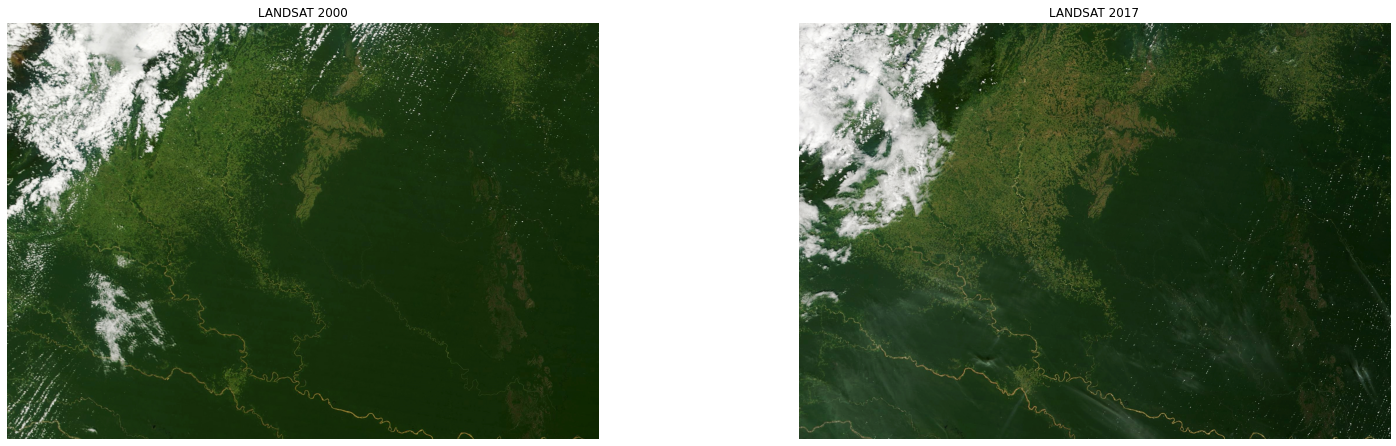

In [2]:
img2000 = imageio.imread("LANDSAT2000.png")
img2017 = imageio.imread("LANDSAT2017.png")

img2000 = np.array(img2000).astype(np.uint8)
img2017 = np.array(img2017).astype(np.uint8)

plt.figure(figsize=(26,26))
plt.subplot(321); plt.imshow(img2000); plt.axis('off'); plt.title('LANDSAT 2000')
plt.subplot(322); plt.imshow(img2017); plt.axis('off'); plt.title('LANDSAT 2017')

Because the images are in RGB mode, the filters may be applied in different color channels, so let's define some functions to load and plot each channel separately.

In [3]:
def get_rgb_channels(image):
  R = np.array(image[:,:,0])
  G = np.array(image[:,:,1])
  B = np.array(image[:,:,2])
  return R, G, B

def plot_rgb_channels(image, title):
  (R, G, B) = get_rgb_channels(image)
  plt.figure(figsize=(13,13))
  plt.subplot(323); plt.imshow(R, cmap="gray"); plt.axis('off'); plt.title('%s - Red Channel' % title)
  plt.subplot(324); plt.imshow(G, cmap="gray"); plt.axis('off'); plt.title('%s - Green Channel' % title)
  plt.subplot(325); plt.imshow(B, cmap="gray"); plt.axis('off'); plt.title('%s - Blue Channel' % title)

**Clouds Removal**

The first step to prepare the image is to remove the clouds because they have the highest values in the image and are useless to the objectives of this work.


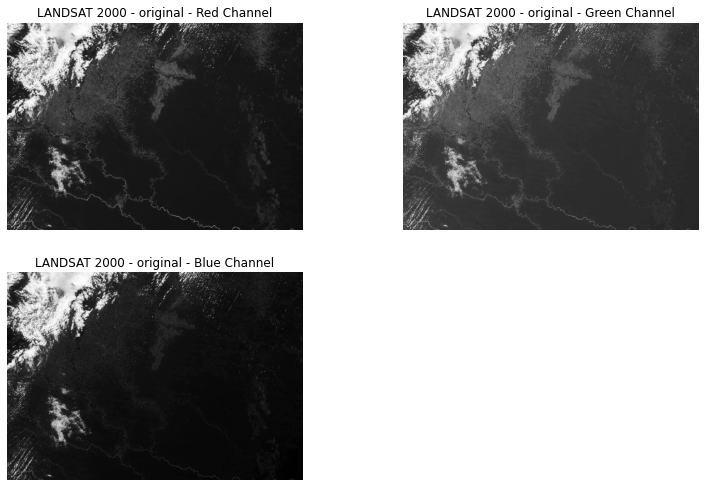

In [4]:
plot_rgb_channels(img2000, "LANDSAT 2000 - original")

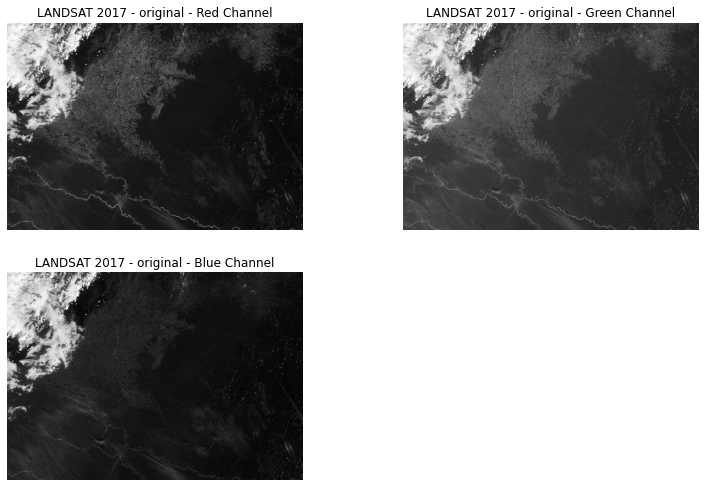

In [5]:
plot_rgb_channels(img2017, "LANDSAT 2017 - original")

The images of the RGB channels viewed separatelly shows that the clouds are best defined in the *Blue* channel. So the function that recovers the cloud area uses the high intensity values in this channel to compute them in the image.

In [6]:
def get_clouds(image, limit):
  (R, G, B) = get_rgb_channels(image)
  B_uint8 = img_as_ubyte(exposure.rescale_intensity(B))
  return B_uint8 > limit

After lots of attempts, the best intensity value found to be applied as lowest intensity value accepted in the blue channel was 100. All pixels with intensity value higher than this are considered as part of a cloud.

Text(0.5, 1.0, 'Cloud area in LANDSCAPE 2017 image')

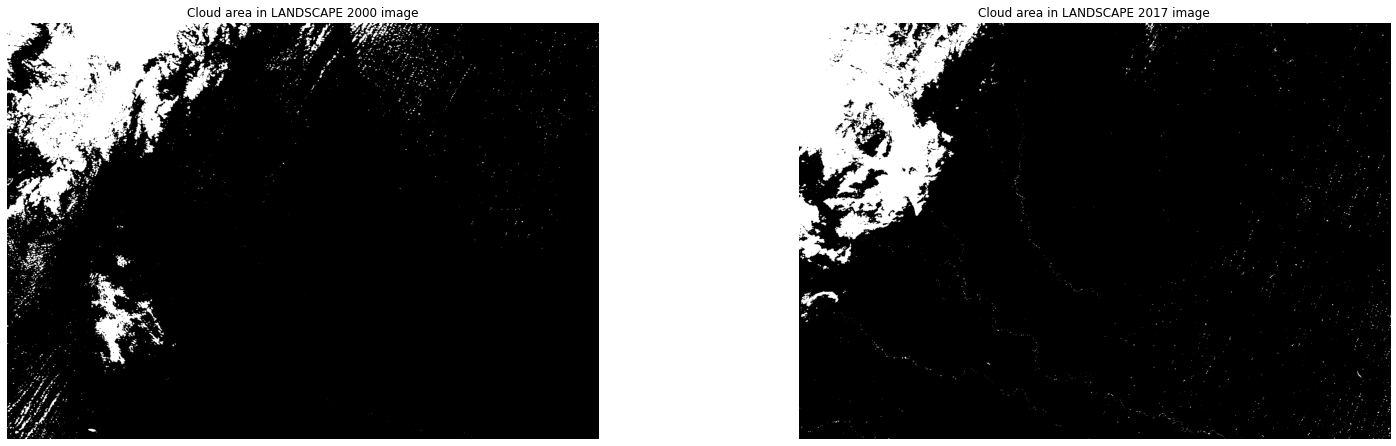

In [7]:
clouds_1 = get_clouds(img2000, 100)
clouds_2 = get_clouds(img2017, 100)

plt.figure(figsize=(26,26))
plt.subplot(323); plt.imshow(clouds_1, cmap="gray"); plt.axis('off'); plt.title('Cloud area in LANDSCAPE 2000 image')
plt.subplot(324); plt.imshow(clouds_2, cmap="gray"); plt.axis('off'); plt.title('Cloud area in LANDSCAPE 2017 image')

The images above show that the cloud area in each image are different, but both of them cannot be used to the calculus of deforestation because we can't count on any of them in both images.

Because of that the cloud area is considered as the union of both.

Text(0.5, 1.0, 'Area to be removed with the union of both cloud areas')

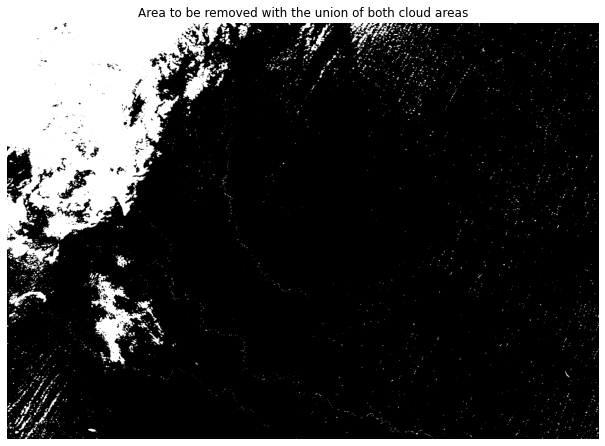

In [8]:
area = np.logical_or(clouds_1, clouds_2)

plt.figure(figsize=(26,26))
plt.subplot(323); plt.imshow(area, cmap="gray"); plt.axis('off'); plt.title('Area to be removed with the union of both cloud areas')

Now we can remove the indicated area from the images replacing them with 0 value and then rescale the intensity values resulted in the range of 0 to 255.

In [30]:
def remove_area(image, area):
  (R, G, B) = get_rgb_channels(image)

  R[area] = 0
  G[area] = 0
  B[area] = 0

  removed = np.array(image, copy=True)
  removed[:,:,0] = R
  removed[:,:,1] = G
  removed[:,:,2] = B

  return exposure.rescale_intensity(removed)

img2000_1 = remove_area(img2000, area)
img2017_1 = remove_area(img2017, area)

Text(0.5, 1.0, 'LANDSAT 2000 - clouds removed')

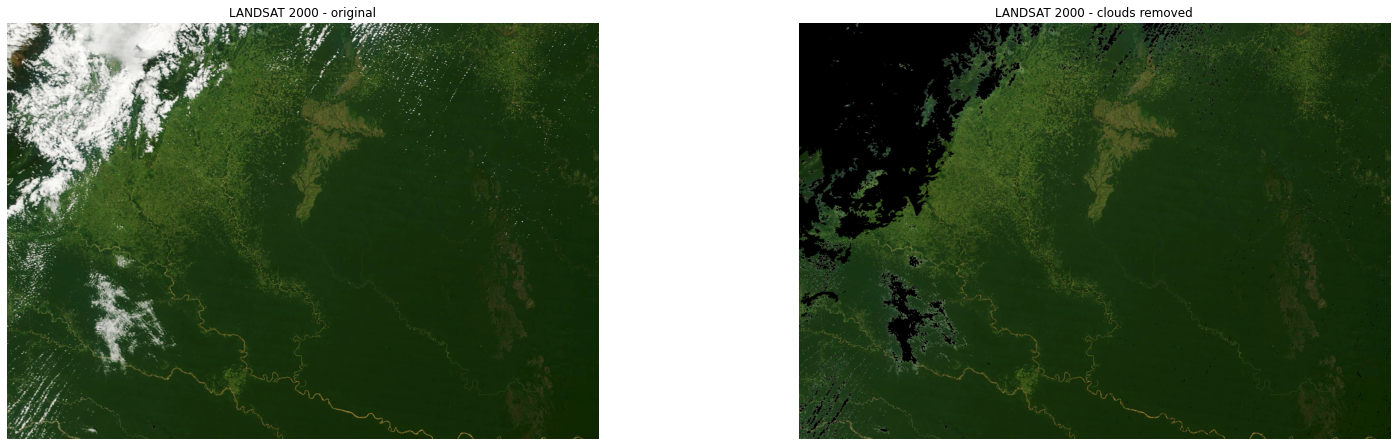

In [10]:
plt.figure(figsize=(26,26))
plt.subplot(323); plt.imshow(img2000); plt.axis('off'); plt.title('LANDSAT 2000 - original')
plt.subplot(324); plt.imshow(img2000_1); plt.axis('off'); plt.title('LANDSAT 2000 - clouds removed')

Text(0.5, 1.0, 'LANDSAT 2017 - clouds removed')

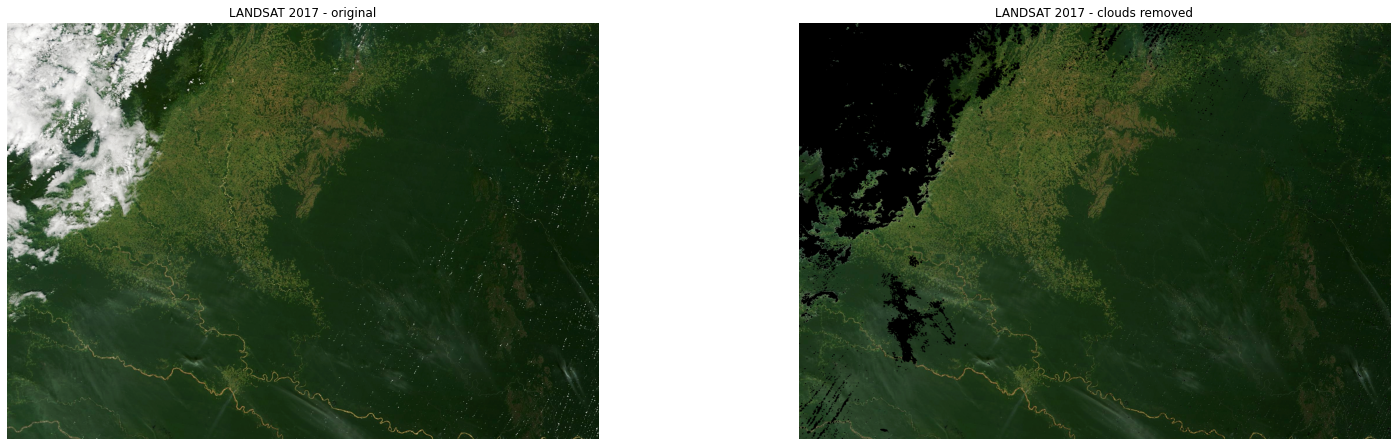

In [12]:
plt.figure(figsize=(26,26))
plt.subplot(323); plt.imshow(img2017); plt.axis('off'); plt.title('LANDSAT 2017 - original')
plt.subplot(324); plt.imshow(img2017_1); plt.axis('off'); plt.title('LANDSAT 2017 - clouds removed')

Both new images without clouds can be seen next.

Text(0.5, 1.0, 'LANDSAT 2017 - clouds removed')

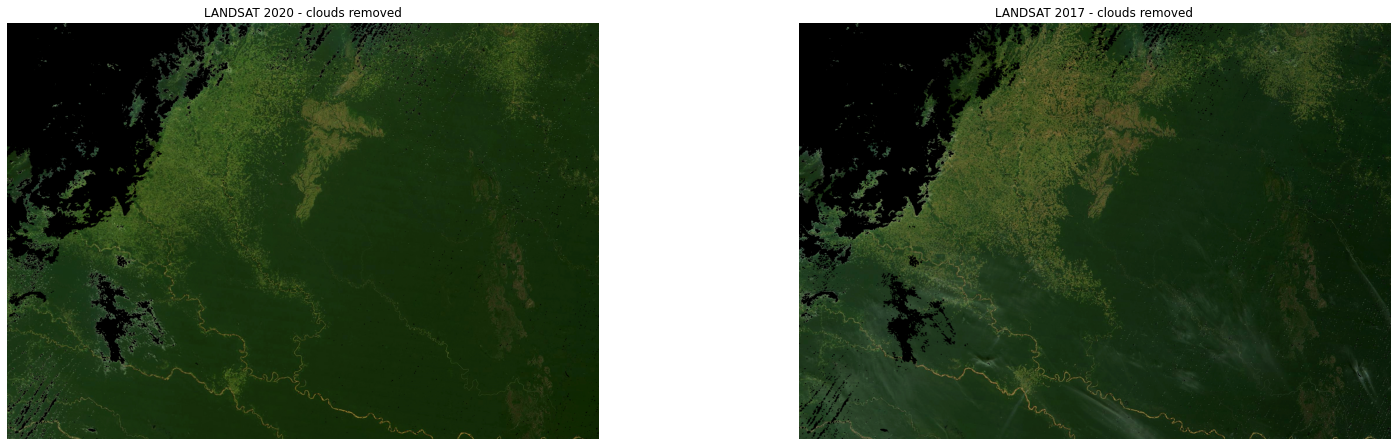

In [13]:
plt.figure(figsize=(26,26))
plt.subplot(323); plt.imshow(img2000_1); plt.axis('off'); plt.title('LANDSAT 2020 - clouds removed')
plt.subplot(324); plt.imshow(img2017_1); plt.axis('off'); plt.title('LANDSAT 2017 - clouds removed')

**Increase contrast of deforested areas**

To delimit the deforested areas, an Adaptive Histogram Equalization filter is applied on both images to saturate different regions of the image and increase the delimitation of the edges of some areas.

Different from the traditional Histogram Equalization that uses the image histogram as base for the transformation filter applied in all pixels equally, this algorithm splits the image in several regions and creates different histograms for each one of them. Those are used to apply a histogram equalization filter in the regions separatelly. 

It's usage is recommended when there are high difference of intensity values in the image in specific regions, where the traditional histogram equalization does not work so well. Because the images lots of forest areas, this is the best approach to ignore the low intensity values of them and increase the contrast in the deforested areas.

In [14]:
def increase_contrast(img, title, value=0.0077):
  # Adaptive Histogram Equalization
  result = exposure.equalize_adapthist(img, clip_limit=value)

  plt.figure(figsize=(26,26))
  plt.subplot(323); plt.imshow(result); plt.axis('off'); plt.title('%s - Adaptative Histogram Equalization Filter' % title)
  return result

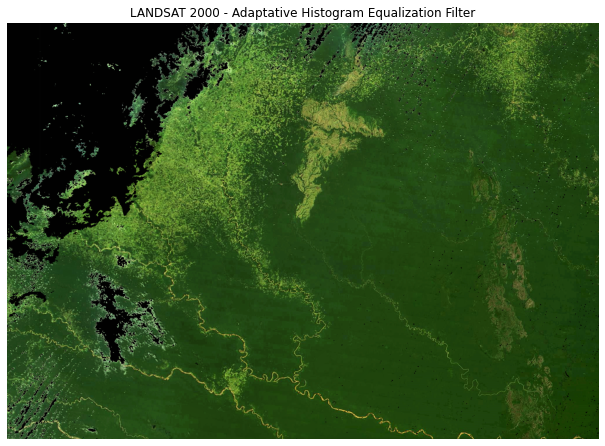

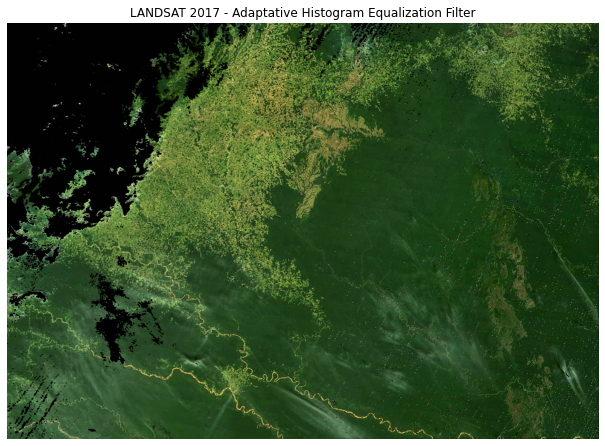

In [15]:
img2000_2 = increase_contrast(img2000_1, "LANDSAT 2000")
img2017_2 = increase_contrast(img2017_1, "LANDSAT 2017")

**Extract deforested area from the images**

Text(0.5, 1.0, 'LANDSAT 2017 - Gray scale')

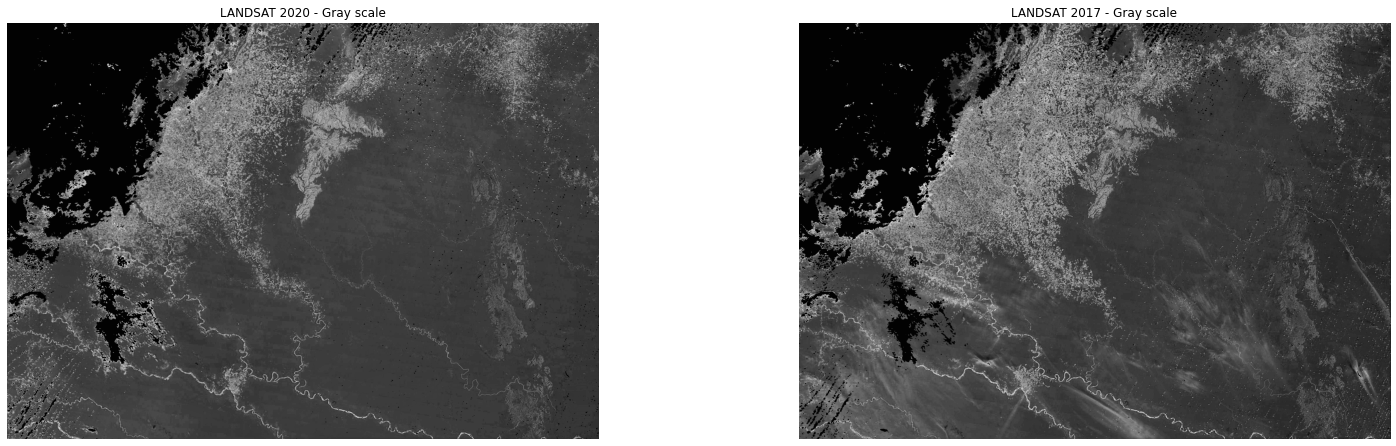

In [23]:
img2000_3 = color.rgb2gray(img2000_2)
img2017_3 = color.rgb2gray(img2017_2)

plt.figure(figsize=(26,26))
plt.subplot(323); plt.imshow(img2000_3, cmap="gray"); plt.axis('off'); plt.title('LANDSAT 2020 - Gray scale')
plt.subplot(324); plt.imshow(img2017_3, cmap="gray"); plt.axis('off'); plt.title('LANDSAT 2017 - Gray scale')

Text(0.5, 1.0, 'LANDSAT 2017 - OTSU Threshold Filter')

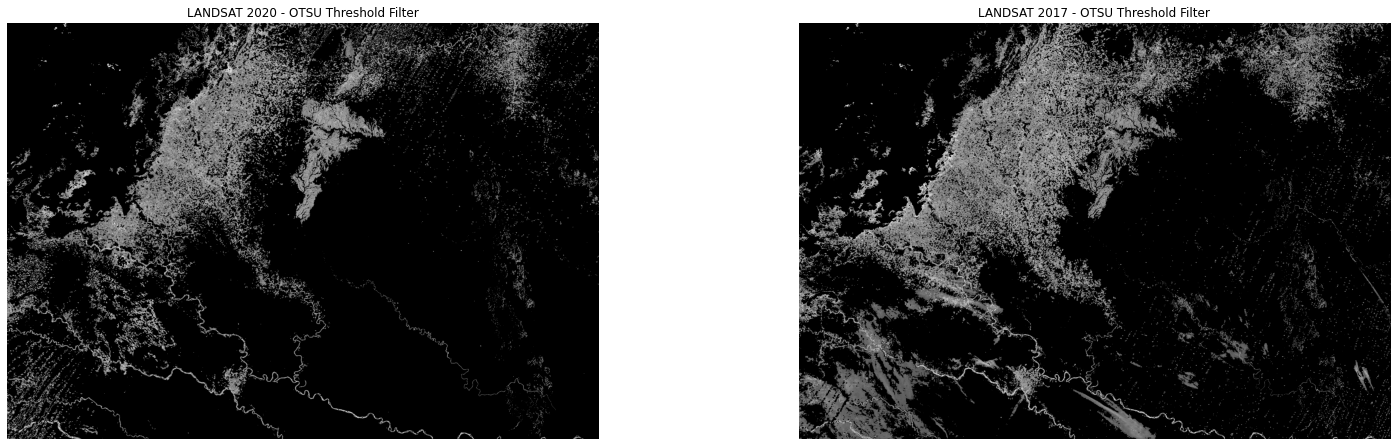

In [17]:
thresh = threshold_otsu(img2000_3)
img2000_4 = np.array(img2000_3, copy=True)
img2000_4[img2000_4 < thresh] = 0

thresh = threshold_otsu(img2017_3)
img2017_4 = np.array(img2017_3, copy=True)
img2017_4[img2017_4 < thresh] = 0

plt.figure(figsize=(26,26))
plt.subplot(323); plt.imshow(img2000_4, cmap="gray"); plt.axis('off'); plt.title('LANDSAT 2020 - OTSU Threshold Filter')
plt.subplot(324); plt.imshow(img2017_4, cmap="gray"); plt.axis('off'); plt.title('LANDSAT 2017 - OTSU Threshold Filter')

**Calculates the increase of deforestation**

Text(0.5, 1.0, 'Difference of images in gray scale')

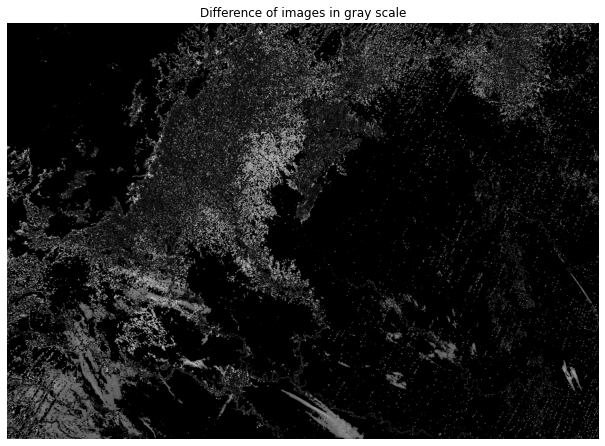

In [18]:
diff =  compare_images(img2017_4, img2000_4, method='diff')
plt.figure(figsize=(26,26))
plt.subplot(323); plt.imshow(diff, cmap="gray"); plt.axis('off'); plt.title('Difference of images in gray scale')

In [28]:
print("Different intensity values in the gray channel: %d" % len(set(diff.flatten())))

Different intensity values in the gray channel: 735528


Different intensity values in the gray channel: 10


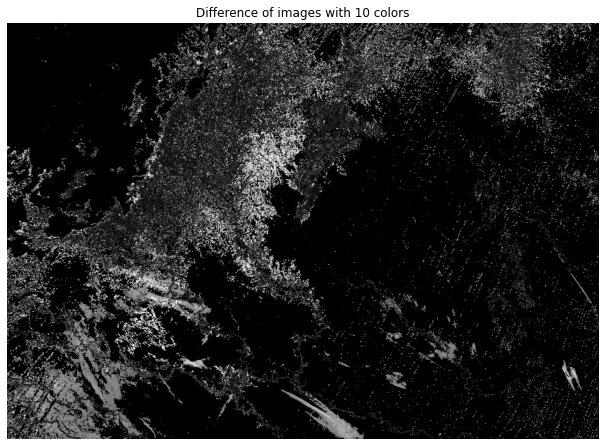

In [29]:
diff = np.array(diff, dtype=np.float64) / 255
image_array = diff.reshape((-1, 1))
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(image_array)

diff10 = np.choose(kmeans.labels_, kmeans.cluster_centers_.squeeze())
diff10.shape = diff.shape

plt.figure(figsize=(26,26))
plt.subplot(323); plt.imshow(diff10, cmap="gray"); plt.axis('off'); plt.title('Difference of images with 10 colors')
print("Different intensity values in the gray channel: %d" % len(set(diff10.flatten())))

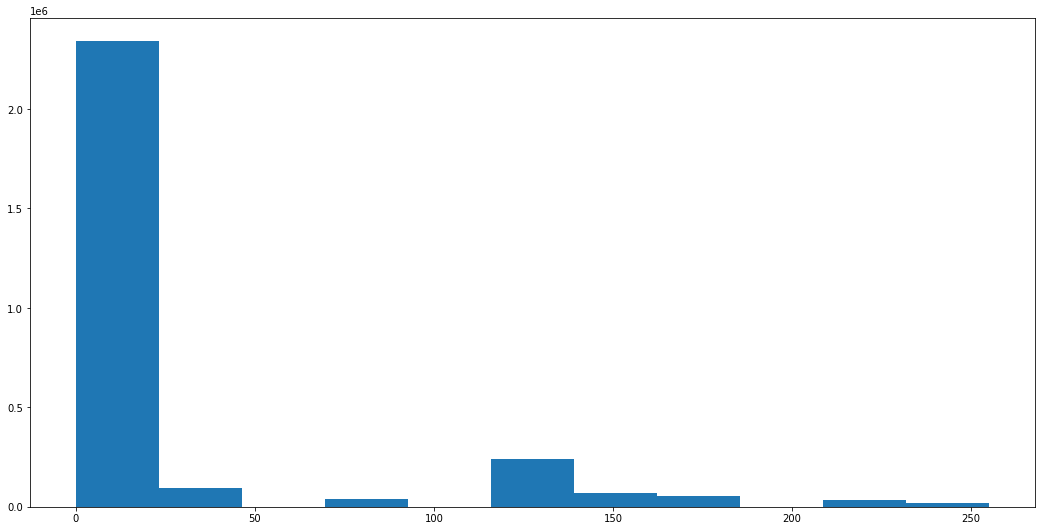

Deforastation of 0%: (intensity = 0, count = 2342954, ha = 0.00)
Deforastation of 10%: (intensity = 23, count = 93703, ha = 843.33)
Deforastation of 20%: (intensity = 46, count = 0, ha = 0.00)
Deforastation of 30%: (intensity = 69, count = 41520, ha = 1121.04)
Deforastation of 40%: (intensity = 92, count = 0, ha = 0.00)
Deforastation of 50%: (intensity = 115, count = 240549, ha = 10824.71)
Deforastation of 60%: (intensity = 139, count = 70891, ha = 3828.11)
Deforastation of 70%: (intensity = 162, count = 53570, ha = 3374.91)
Deforastation of 80%: (intensity = 185, count = 0, ha = 0.00)
Deforastation of 90%: (intensity = 208, count = 33714, ha = 2730.83)
Deforastation of 100%: (intensity = 231, count = 18482, ha = 1663.38)

Estimated number of deforested hectares: 24386.31 ha


In [20]:
plt.figure(figsize=(18, 9))
bins = 11
img = img_as_ubyte(exposure.rescale_intensity(diff10))
arr = plt.hist(img.ravel(), bins=bins)
plt.show()

deforestation = np.zeros(bins)
pixel_per_ha = 0.09

for i in range(bins):
  deforestation[i] = arr[0][i] * pixel_per_ha * i * 0.1
  print("Deforastation of %d%%: (intensity = %d, count = %d, ha = %.2f)" % ((i * 10), arr[1][i], arr[0][i], deforestation[i]))

print("\nEstimated number of deforested hectares: %.2f ha" % np.sum(deforestation))